In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gzip
import pickle
from global_settings import * 
from df_utils import * 
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

In [2]:
# Just change this parameter to get the plots for each run 
run = "run1"

if(run=="run1"):
    run_flag="NuMI Run 1"

else:
    run_flag="NuMI Run 3"
    

# Change to  your own paths accordingly 

# Path to where the pickle files are stored 
samples_dir = "/home/lmlepin/Desktop/dm_sets/dark_tridents_analysis/" + run + "samples/"

# Path to where you want to store your plots 
fig_dir = "/home/lmlepin/Desktop/Plots_DT_Drive/2023/multisim_var/"

df = pd.read_pickle(run + "_CV_high_stats_with_scores.pkl")
df = filter_df(df,'signal_score')
df = Edit_Weight_Tune(df)
MC_weight_branch(df)
'''
weight_PPFX=df.iloc[:,8]
weight_GENIE=df.iloc[:,9]
weight_Reint=df.iloc[:,10]
cv=df.iloc[:,13]
'''
#df = df[df['signal_score'] >=0.]

weight_PPFX=df['weightsPPFX']
weight_GENIE=df['weightsGenie']
weight_Reint=df['weightsReint']
cv=df['signal_score']

cv=logit_transform(cv)
PPFX=np.array(weight_PPFX)/1000
GENIE=np.array(weight_GENIE)/1000
Reint=np.array(weight_Reint)/1000

In [3]:
# General settings:
n_x_bins = 8
n_y_bins = 30
y_up = 0. 


if(run=='run1'):
    y_up = 250.
    binning =  my_custom_bins
else:
    y_up = 800.
    binning =  my_custom_bins

multisim_range = np.array(([(0., binning[-1]), (0., y_up)]))


xy_binning = (final_custom_bins, n_y_bins)
x_binning = final_custom_bins

cmin_treshold = 1e-10

# This is in case we need to add the POT scaling 
Norm = 1.0 

# List to store error histograms 

error_hists = []
abs_error_hists = []

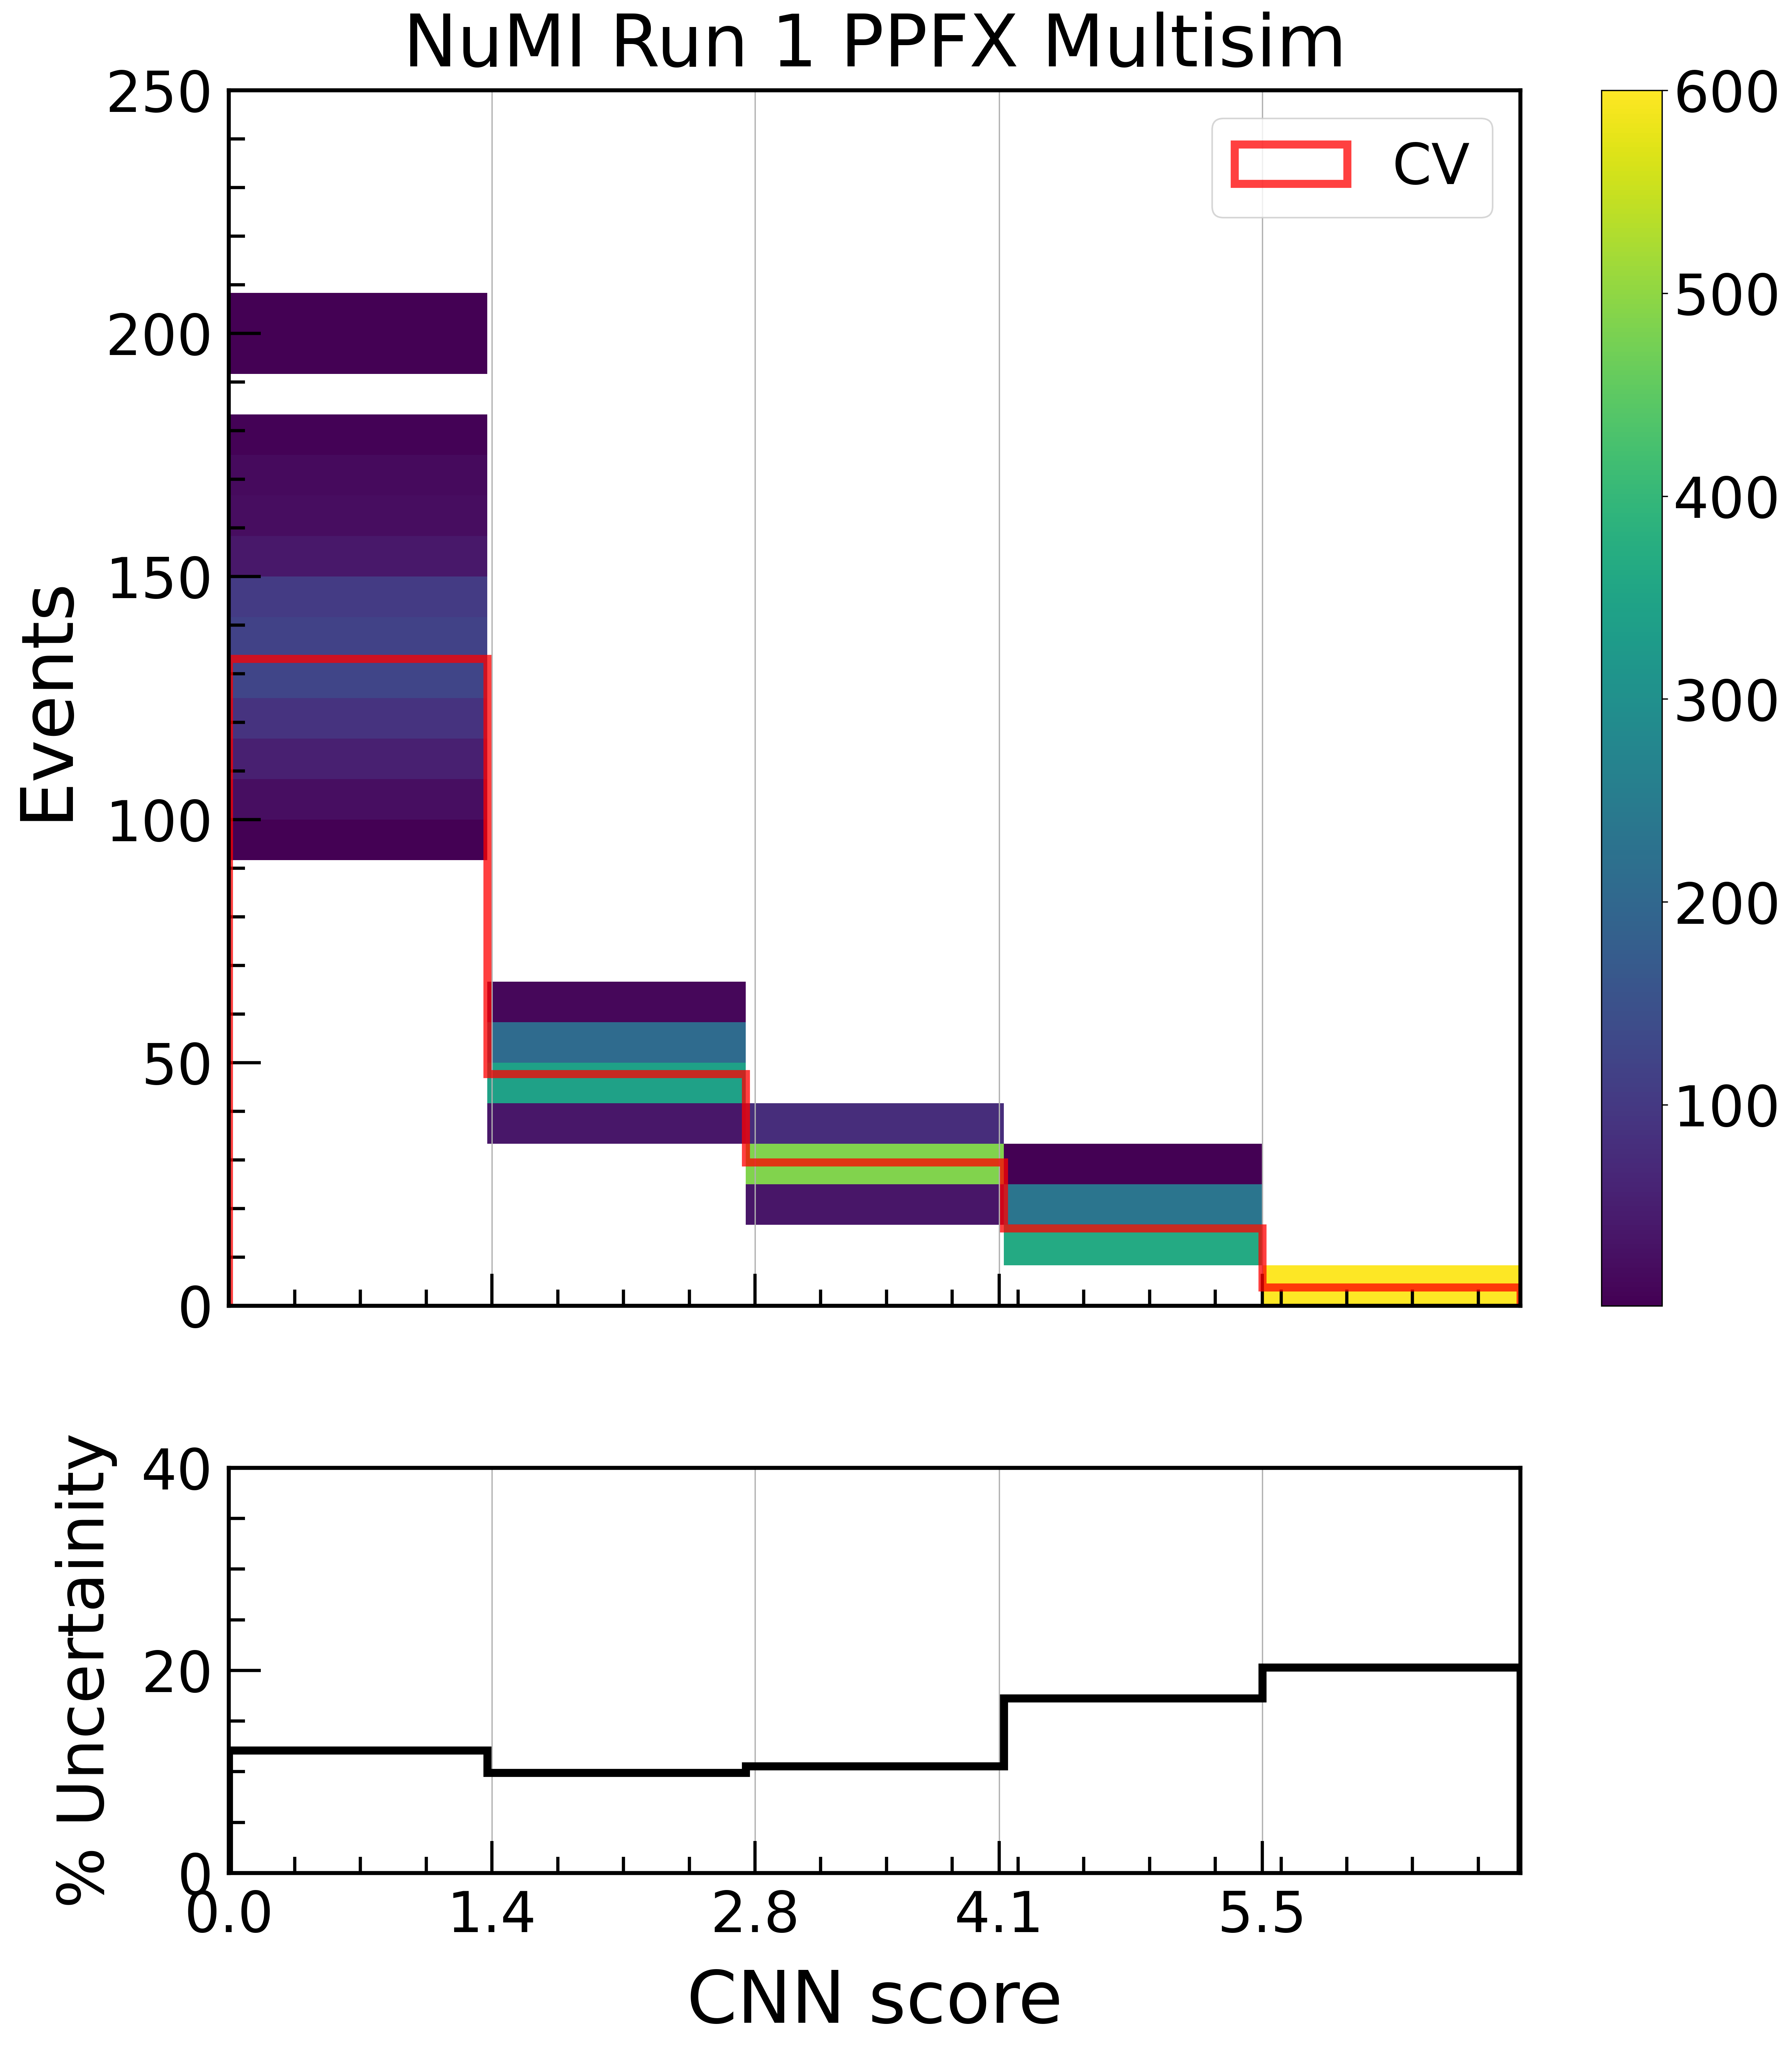

In [4]:

NUniverses = 600

n_tot = np.empty([NUniverses,len(binning) -1])
n_cv_tot = np.empty([len(binning) - 1])
n_tot.fill(0)
n_cv_tot.fill(0)

spline_fix_cv  = df["weight"]*Norm
spline_fix_var = df["weight"]*Norm



fig,ax = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=[18,20],dpi=300)

for axis in ['top', 'bottom', 'left', 'right']:
    ax[0].spines[axis].set_linewidth(2.5)  # change width
    ax[0].spines[axis].set_color('black')    # change color
    
for axis in ['top', 'bottom', 'left', 'right']:
    ax[1].spines[axis].set_linewidth(2.5)  # change width
    ax[1].spines[axis].set_color('black')    # change color
    
ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())
    
plt.sca(ax[0])
ax[0].set_ylabel(r'Events',fontsize=45,labelpad=15)
plt.title(run_flag + ' PPFX Multisim',fontsize=45, pad=15)
(counts_std, bins_std) = np.histogram(cv, weights=df['weight'], bins=x_binning)
(counts_fake, bins_final) = np.histogram(cv, weights = df['weight'], bins=final_custom_bins)

n_cv_tot += counts_std 

i=0
x=[]
y=[]


while i < NUniverses:
    weight=[]
    PPFX_w=[]
    for we in PPFX:
        weight.append(we[i])
    weight = pd.DataFrame(weight)
    weight = weight.iloc[:,0].values
    weight[weight == 1]= df["ppfx_cv"].iloc[weight == 1]
    weight[np.isnan(weight)] = df["ppfx_cv"].iloc[np.isnan(weight)]
    weight[weight > 100] = df["ppfx_cv"].iloc[weight > 100]
    weight[weight < 0] = df["ppfx_cv"].iloc[weight < 0]
    weight[weight == np.inf] = df["ppfx_cv"].iloc[weight == np.inf]
    PPFX_w=(weight)
    (counts_we, bins_we) = np.histogram(cv, weights=PPFX_w*np.nan_to_num(spline_fix_var/df["ppfx_cv"]), bins=x_binning)
    n_tot[i] = counts_we 
    x.append(bins_we[:-1])
    y.append(counts_we)
    i=i+1
    

cov = np.empty([len(counts_std), len(counts_std)])
cov.fill(0)    
for n in n_tot:
    for i in range(len(counts_std)):
        for j in range(len(counts_std)):
            cov[i][j] += (n[i] - n_cv_tot[i])*(n[j] - n_cv_tot[j])
            
cov /= NUniverses

    
x=np.array(x)
ana_x=x.flatten()
ana_x=ana_x.tolist()
y=np.array(y)
ana_y=y.flatten()
ana_y=ana_y.tolist()  
plt.hist2d(ana_x,ana_y,bins=xy_binning, range=multisim_range, cmin=cmin_treshold)
plt.hist(bins_final[:-1], bins_final, weights=counts_std, alpha=0.75, histtype='step',label='CV',color='r',lw=5)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=35)
plt.xlim(0.,binning[-1])
plt.ylim(0.,y_up)
plt.legend(fontsize=35)

ax[0].tick_params(axis="y", which='major', direction="in",length=20,width=2.0,pad=10, labelsize=35)
ax[0].tick_params(axis="y", which='minor', direction="in",length=10,width=2.0,labelleft=False, labelsize=35)
ax[0].tick_params(axis="x", which='major', direction="in",length=20,width=2.0,pad=10, bottom=True,top=False,labelbottom=False)
ax[0].tick_params(axis="x", which='minor', direction="in",length=10,width=2.0, bottom=True,top=False,labelbottom=False)
plt.sca(ax[1])
pos = ax[0].get_position()
pos2 = ax[1].get_position()
ax[1].set_position([pos.x0,pos2.y0,pos.width,pos2.height])
ax[1].tick_params(axis='both', which='major',direction="in", length=20, width=2.0, labelsize=35,pad=10)
ax[1].tick_params(axis='both', which='minor',direction="in", length=10, width=2.0, labelsize=35,pad=10)
ax[0].grid(axis='x')
ax[1].grid(axis='x')
ax[0].set_xticks(np.round(bins_final,1))
ax[1].set_xticks(np.round(bins_final,1))
plt.hist(bins_final[:-1],bins_final,weights=np.sqrt(np.diag(cov))/n_cv_tot*100, color = "black", histtype="step",lw=5,linestyle="-")
error_hists.append((bins_final,np.sqrt(np.diag(cov))/n_cv_tot*100))
abs_error_hists.append((bins_final,np.sqrt(np.diag(cov))))
plt.ylabel("% Uncertainity",fontsize=40,labelpad=15)
ax[1].set_xlabel("CNN score",fontsize=45,labelpad=15)
plt.ylim(0,40)
plt.xlim(0.,final_custom_bins[-1])
plt.savefig(fig_dir + run + "_CNN_PPFX_uncertainty.pdf",bbox_inches="tight")
plt.savefig(fig_dir + run + "_CNN_PPFX_uncertainty.png",bbox_inches="tight") 

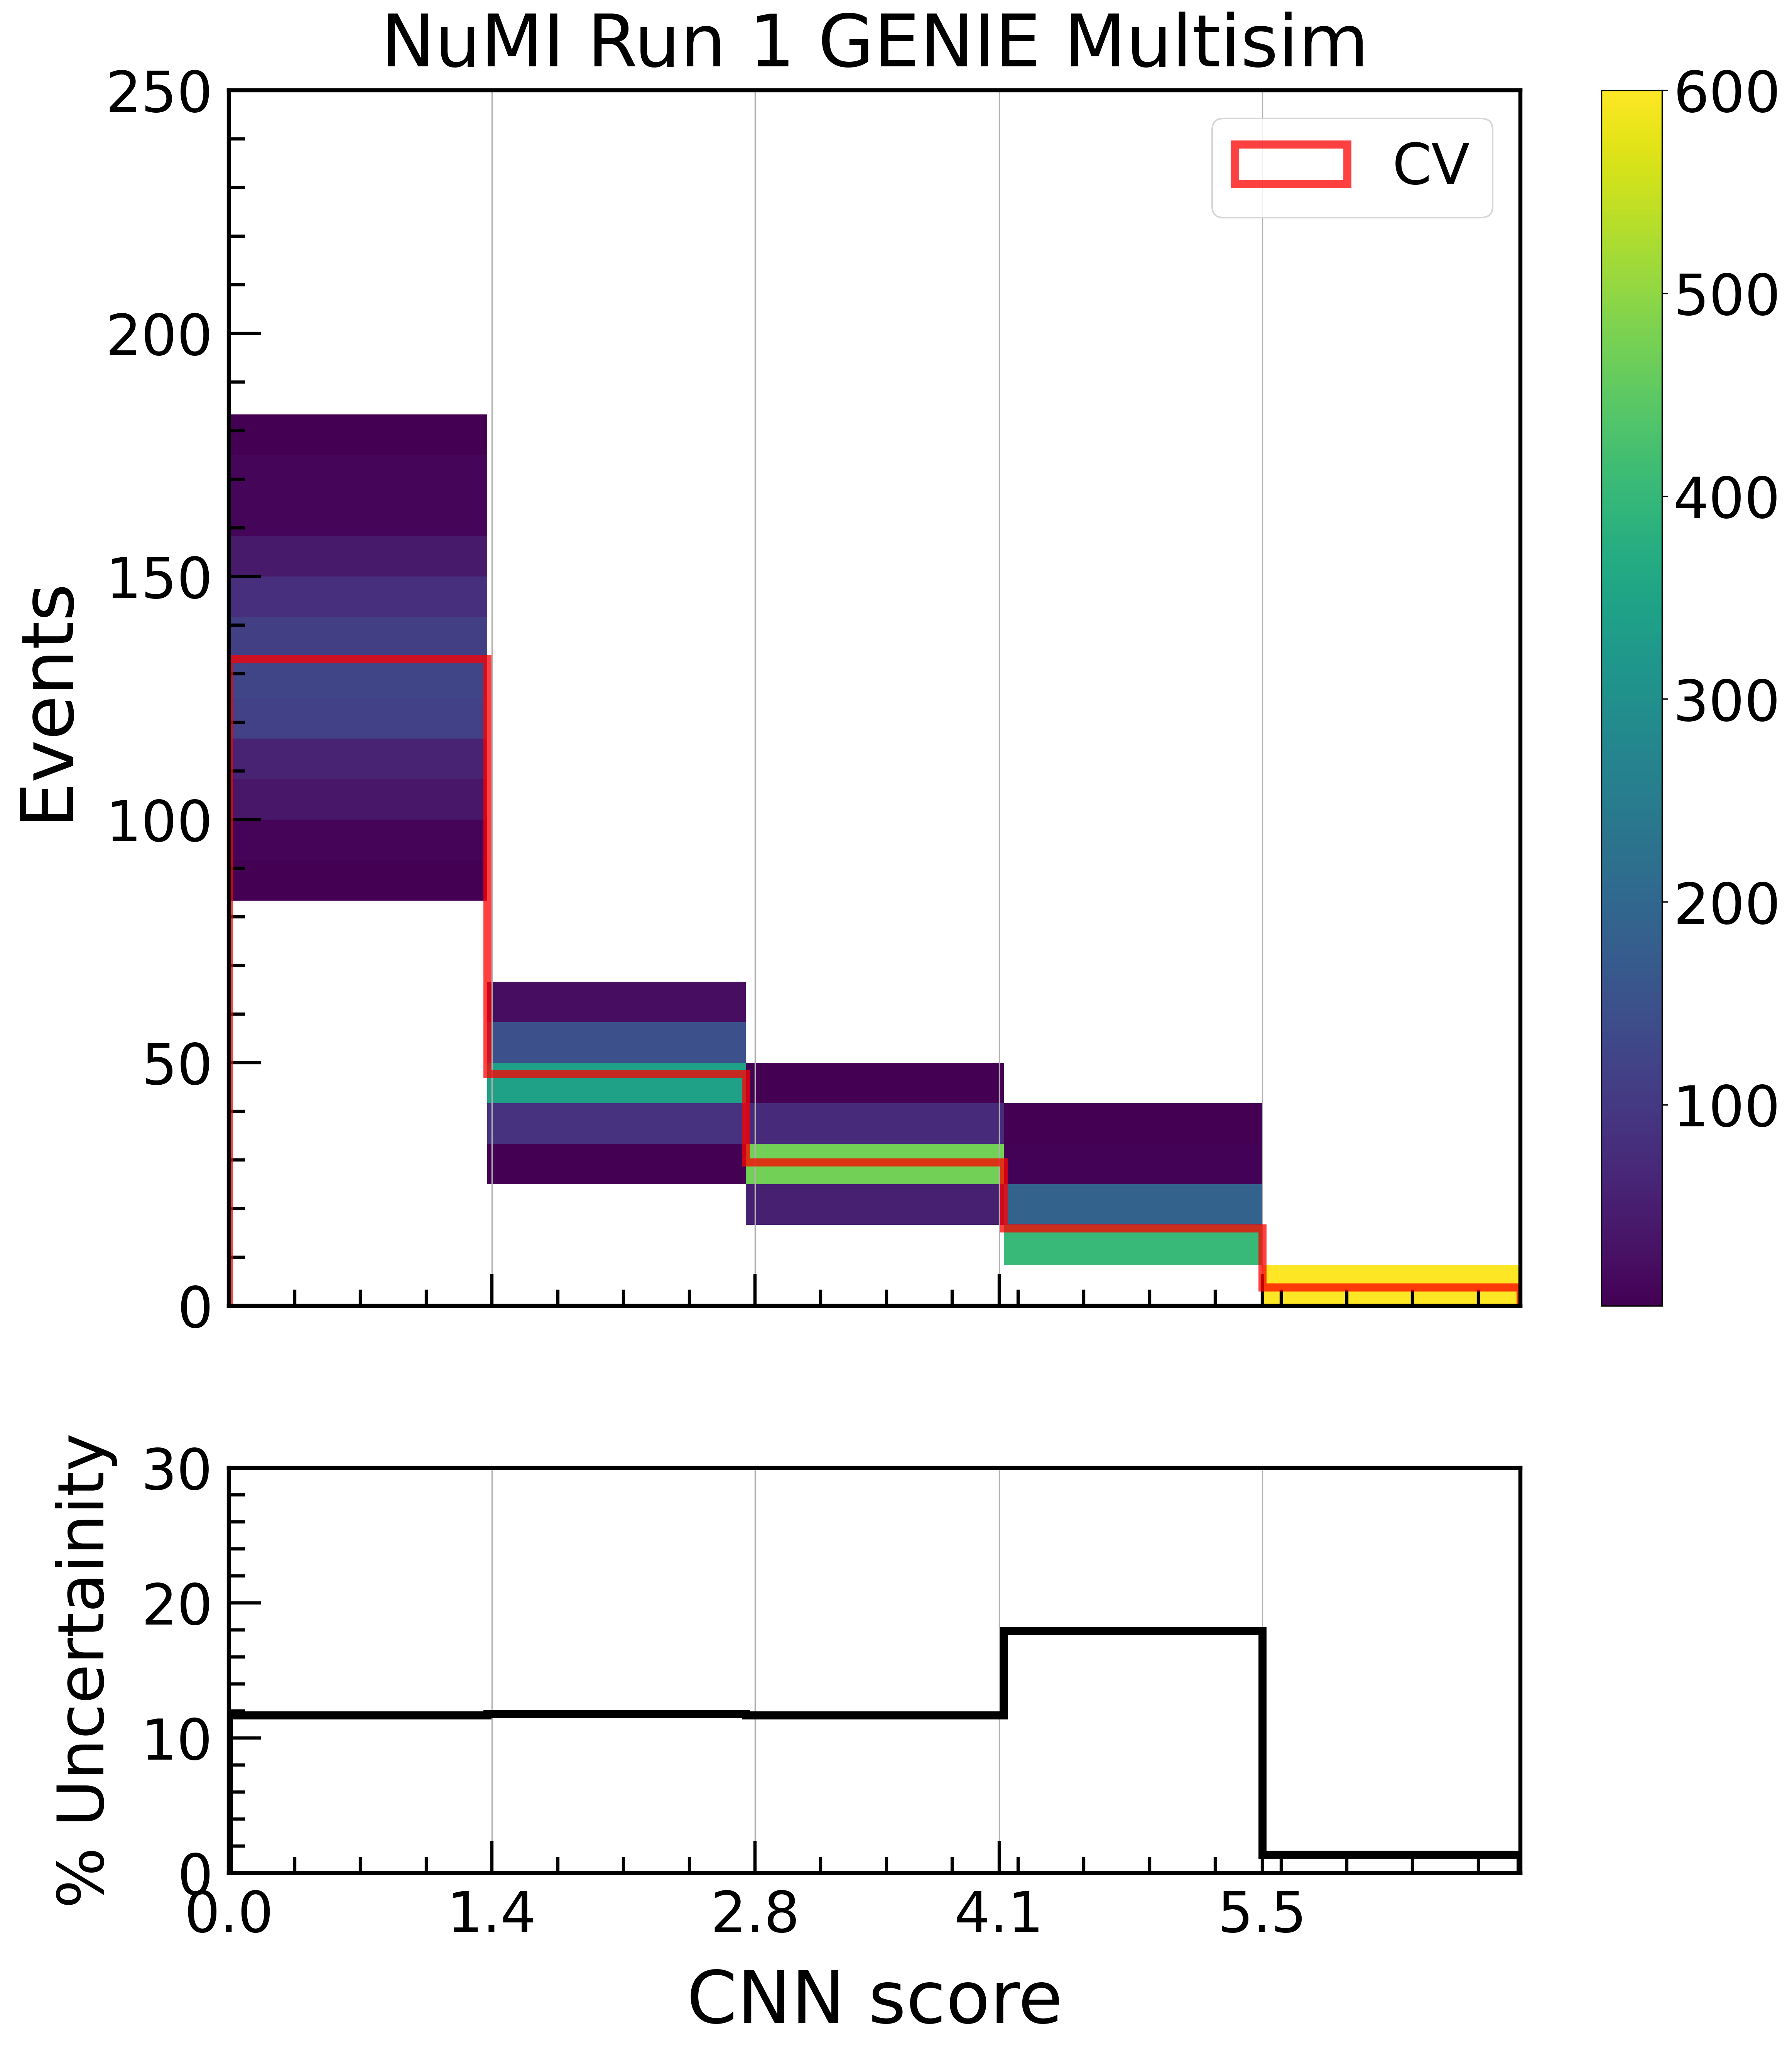

In [5]:
NUniverses = 600

n_tot = np.empty([NUniverses,len(binning)-1])
n_cv_tot = np.empty([len(binning) -1])
n_tot.fill(0)
n_cv_tot.fill(0)



fig,ax = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=[18,20],dpi=300)

for axis in ['top', 'bottom', 'left', 'right']:
    ax[0].spines[axis].set_linewidth(2.5)  # change width
    ax[0].spines[axis].set_color('black')    # change color
    
for axis in ['top', 'bottom', 'left', 'right']:
    ax[1].spines[axis].set_linewidth(2.5)  # change width
    ax[1].spines[axis].set_color('black')    # change color
    
ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())    

plt.sca(ax[0])
ax[0].set_ylabel(r'Events',fontsize=45,labelpad=15)
plt.title(run_flag + ' GENIE Multisim',fontsize=45, pad =15)
(counts_std, bins_std) = np.histogram(cv, weights = df['weight'], bins=x_binning)
(counts_fake, bins_final) = np.histogram(cv, weights = df['weight'], bins=final_custom_bins)

n_cv_tot += counts_std 

i=0
x=[]
y=[]


while i < NUniverses:
    weight=[]
    genie_w=[]
    for we in GENIE:
        weight.append(we[i])
    weight = pd.DataFrame(weight)
    weight = weight.iloc[:,0].values
    weight[weight == 1]= df["weightSplineTimesTune"].iloc[weight == 1]
    weight[np.isnan(weight)] = df["weightSplineTimesTune"].iloc[np.isnan(weight)]
    weight[weight > 50] = df["weightSplineTimesTune"].iloc[weight > 50] # why 30 not 50?
    weight[weight <= 0] = df["weightSplineTimesTune"].iloc[weight <= 0]
    weight[weight == np.inf] = df["weightSplineTimesTune"].iloc[weight == np.inf]
    genie_w=(weight)
    (counts_we, bins_we) = np.histogram(cv, weights=genie_w*spline_fix_var/df["weightSplineTimesTune"], bins=x_binning)
    n_tot[i] = counts_we 
    x.append(bins_we[:-1])
    y.append(counts_we)
    i=i+1
    

cov = np.empty([len(counts_std), len(counts_std)])
cov.fill(0)    
for n in n_tot:
    for i in range(len(counts_std)):
        for j in range(len(counts_std)):
            cov[i][j] += (n[i] - n_cv_tot[i])*(n[j] - n_cv_tot[j])
            
cov /= NUniverses

x=np.array(x)
ana_x=x.flatten()
ana_x=ana_x.tolist()
y=np.array(y)
ana_y=y.flatten()
ana_y=ana_y.tolist()  
plt.hist2d(ana_x,ana_y,bins=xy_binning, range=multisim_range, cmin=cmin_treshold)
plt.hist(bins_final[:-1], bins_final, weights=counts_std, alpha=0.75, histtype='step',label='CV',color='r',lw=5)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=35)
plt.xlim(0.,binning[-1])
plt.ylim(0.,y_up)
plt.legend(fontsize=35)

ax[0].tick_params(axis="y", which='major', direction="in",length=20,width=2.0,pad=10, labelsize=35)
ax[0].tick_params(axis="y", which='minor', direction="in",length=10,width=2.0,labelleft=False, labelsize=35)
ax[0].tick_params(axis="x", which='major', direction="in",length=20,width=2.0,pad=10, bottom=True,top=False,labelbottom=False)
ax[0].tick_params(axis="x", which='minor', direction="in",length=10,width=2.0, bottom=True,top=False,labelbottom=False)

plt.sca(ax[1])
pos = ax[0].get_position()
pos2 = ax[1].get_position()
ax[1].set_position([pos.x0,pos2.y0,pos.width,pos2.height])
ax[1].tick_params(axis='both', which='major',direction="in", length=20, width=2.0, labelsize=35,pad=10)
ax[1].tick_params(axis='both', which='minor',direction="in", length=10, width=2.0, labelsize=35,pad=10)

ax[0].grid(axis='x')
ax[1].grid(axis='x')
ax[0].set_xticks(np.round(bins_final,1))
ax[1].set_xticks(np.round(bins_final,1))

plt.hist(bins_final[:-1],bins_final,weights=np.sqrt(np.diag(cov))/n_cv_tot*100, color = "black", histtype="step",lw=5,linestyle="-")
error_hists.append((bins_final,np.sqrt(np.diag(cov))/n_cv_tot*100))
abs_error_hists.append((bins_final,np.sqrt(np.diag(cov))))
plt.ylabel("% Uncertainity",fontsize=40,labelpad=15)
ax[1].set_xlabel("CNN score",fontsize=45,labelpad=15)
plt.ylim(0,30)
plt.xlim(0.,final_custom_bins[-1])
plt.savefig(fig_dir + run + "_CNN_GENIE_uncertainty.pdf",bbox_inches="tight")
plt.savefig(fig_dir + run + "_CNN_GENIE_uncertainty.png",bbox_inches="tight")

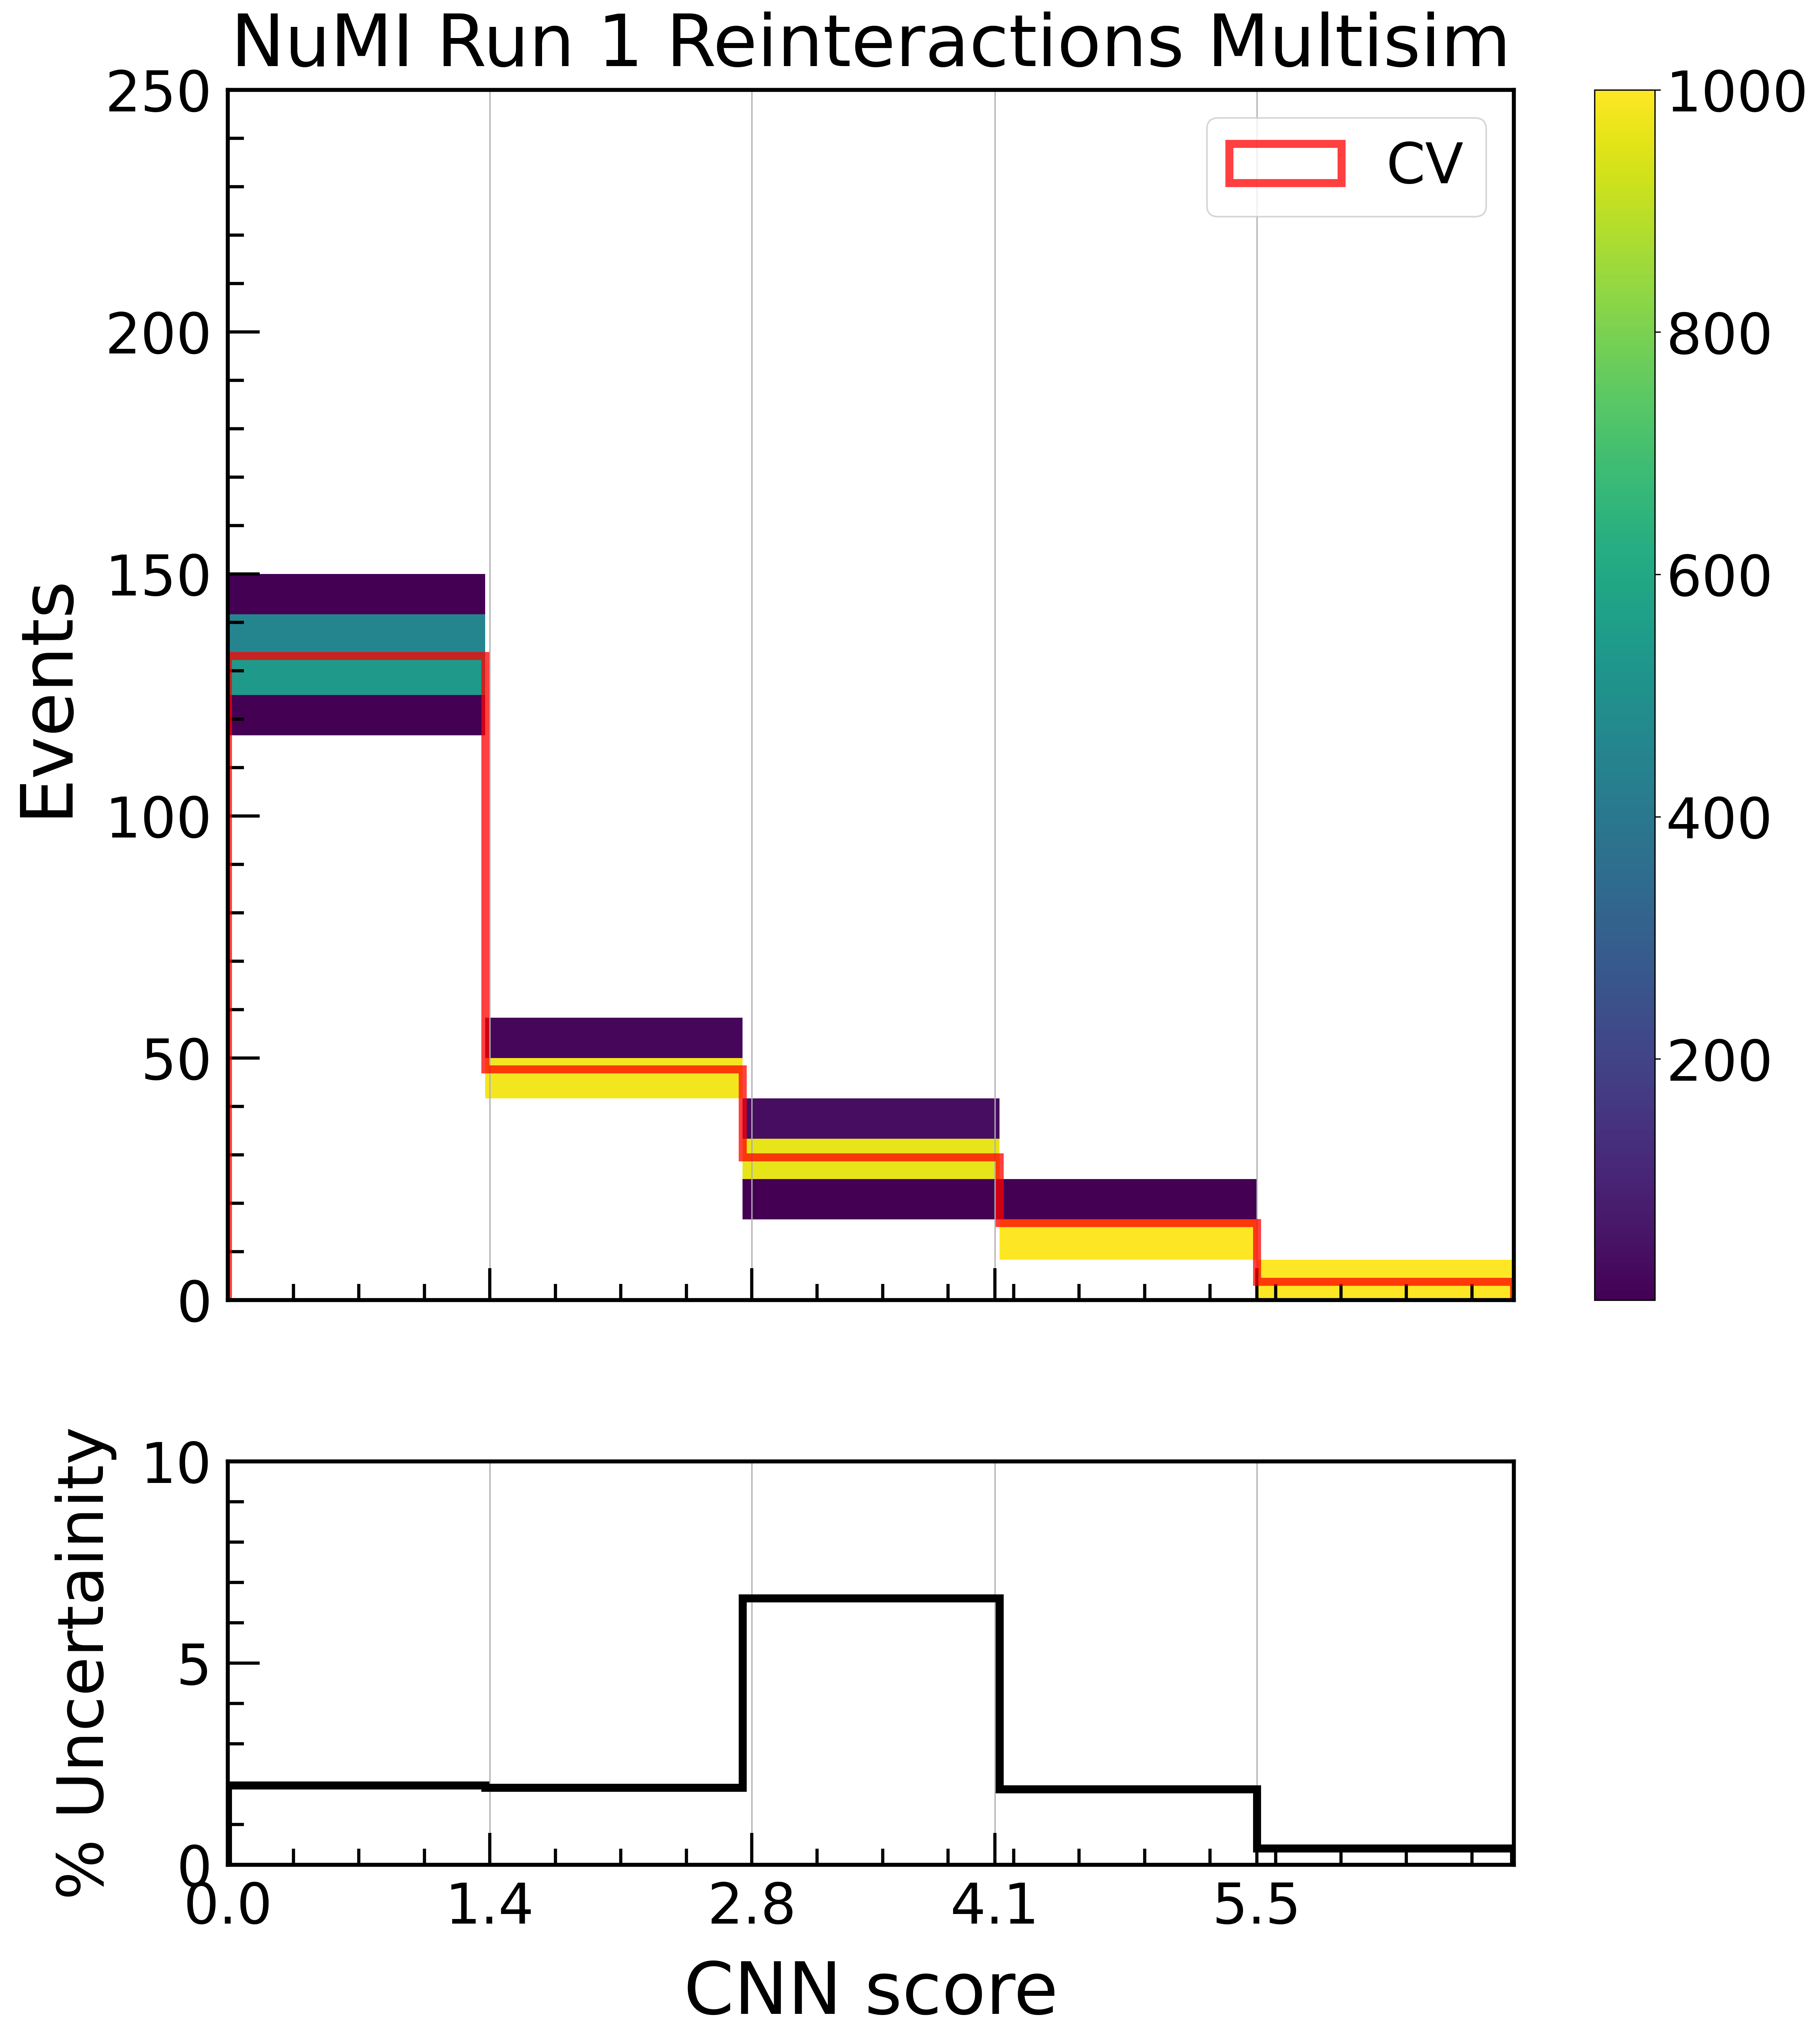

In [6]:
NUniverses = 1000

n_tot = np.empty([NUniverses,len(binning)-1])
n_cv_tot = np.empty([len(binning)-1])
n_tot.fill(0)
n_cv_tot.fill(0)



fig,ax = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=[18,20],dpi=300)

for axis in ['top', 'bottom', 'left', 'right']:
    ax[0].spines[axis].set_linewidth(2.5)  # change width
    ax[0].spines[axis].set_color('black')    # change color
    
for axis in ['top', 'bottom', 'left', 'right']:
    ax[1].spines[axis].set_linewidth(2.5)  # change width
    ax[1].spines[axis].set_color('black')    # change color
    
ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())


plt.sca(ax[0])
ax[0].set_ylabel(r'Events',fontsize=45,labelpad=15)
plt.title(run_flag + ' Reinteractions Multisim',fontsize=45, pad=15)
(counts_std, bins_std) = np.histogram(cv, weights = df['weight'], bins=x_binning)
(counts_fake, bins_final) = np.histogram(cv, weights = df['weight'], bins=final_custom_bins)

n_cv_tot += counts_std 

i=0
x=[]
y=[]


while i < NUniverses:
    weight=[]
    reint_w=[]
    for we in Reint:
        weight.append(we[i])
    weight = pd.DataFrame(weight)
    weight = weight.iloc[:,0].values
    weight[np.isnan(weight)] = 1
    weight[weight > 100] = 1
    weight[weight < 0] = 1
    weight[weight == np.inf] = 1
    reint_w=(weight)
    (counts_we, bins_we) = np.histogram(cv, weights=reint_w*spline_fix_var, bins=x_binning)
    n_tot[i] = counts_we 
    x.append(bins_we[:-1])
    y.append(counts_we)
    i=i+1
    

cov = np.empty([len(counts_std), len(counts_std)])
cov.fill(0)    
for n in n_tot:
    for i in range(len(counts_std)):
        for j in range(len(counts_std)):
            cov[i][j] += (n[i] - n_cv_tot[i])*(n[j] - n_cv_tot[j])
            
cov /= NUniverses

x=np.array(x)
ana_x=x.flatten()
ana_x=ana_x.tolist()
y=np.array(y)
ana_y=y.flatten()
ana_y=ana_y.tolist()  
plt.hist2d(ana_x,ana_y,bins=xy_binning, range=multisim_range, cmin=cmin_treshold)
plt.hist(bins_final[:-1], bins_final, weights=counts_std, alpha=0.75, histtype='step',label='CV',color='r',lw=5)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=35)
plt.xlim(0.,binning[-1])
plt.ylim(0.,y_up)
plt.legend(fontsize=35)

ax[0].tick_params(axis="y", which='major', direction="in",length=20,width=2.0,pad=10, labelsize=35)
ax[0].tick_params(axis="y", which='minor', direction="in",length=10,width=2.0,labelleft=False, labelsize=35)
ax[0].tick_params(axis="x", which='major', direction="in",length=20,width=2.0,pad=10, bottom=True, top=False,labelbottom=False)
ax[0].tick_params(axis="x", which='minor', direction="in",length=10,width=2.0, bottom=True,top=False,labelbottom=False)

plt.sca(ax[1])
pos = ax[0].get_position()
pos2 = ax[1].get_position()
ax[1].set_position([pos.x0,pos2.y0,pos.width,pos2.height])
ax[1].tick_params(axis='both', which='major',direction="in", length=20, width=2.0, labelsize=35,pad=10)
ax[1].tick_params(axis='both', which='minor',direction="in", length=10, width=2.0, labelsize=35,pad=10)
ax[0].grid(axis='x')
ax[1].grid(axis='x')
ax[0].set_xticks(np.round(bins_final,1))
ax[1].set_xticks(np.round(bins_final,1))
plt.hist(bins_final[:-1],bins_final,weights=np.sqrt(np.diag(cov))/n_cv_tot*100, color = "black", histtype="step",lw=5,linestyle="-")
error_hists.append((bins_final,np.sqrt(np.diag(cov))/n_cv_tot*100))
abs_error_hists.append((bins_final,np.sqrt(np.diag(cov))))
plt.ylabel("% Uncertainity",fontsize=40,labelpad=15)
ax[1].set_xlabel("CNN score",fontsize=45,labelpad=15)
plt.ylim(0,10)
plt.xlim(0.,final_custom_bins[-1])
plt.savefig(fig_dir + run + "_CNN_reint_uncertainty.pdf",bbox_inches="tight")
plt.savefig(fig_dir + run + "_CNN_reint_uncertainty.png",bbox_inches="tight")

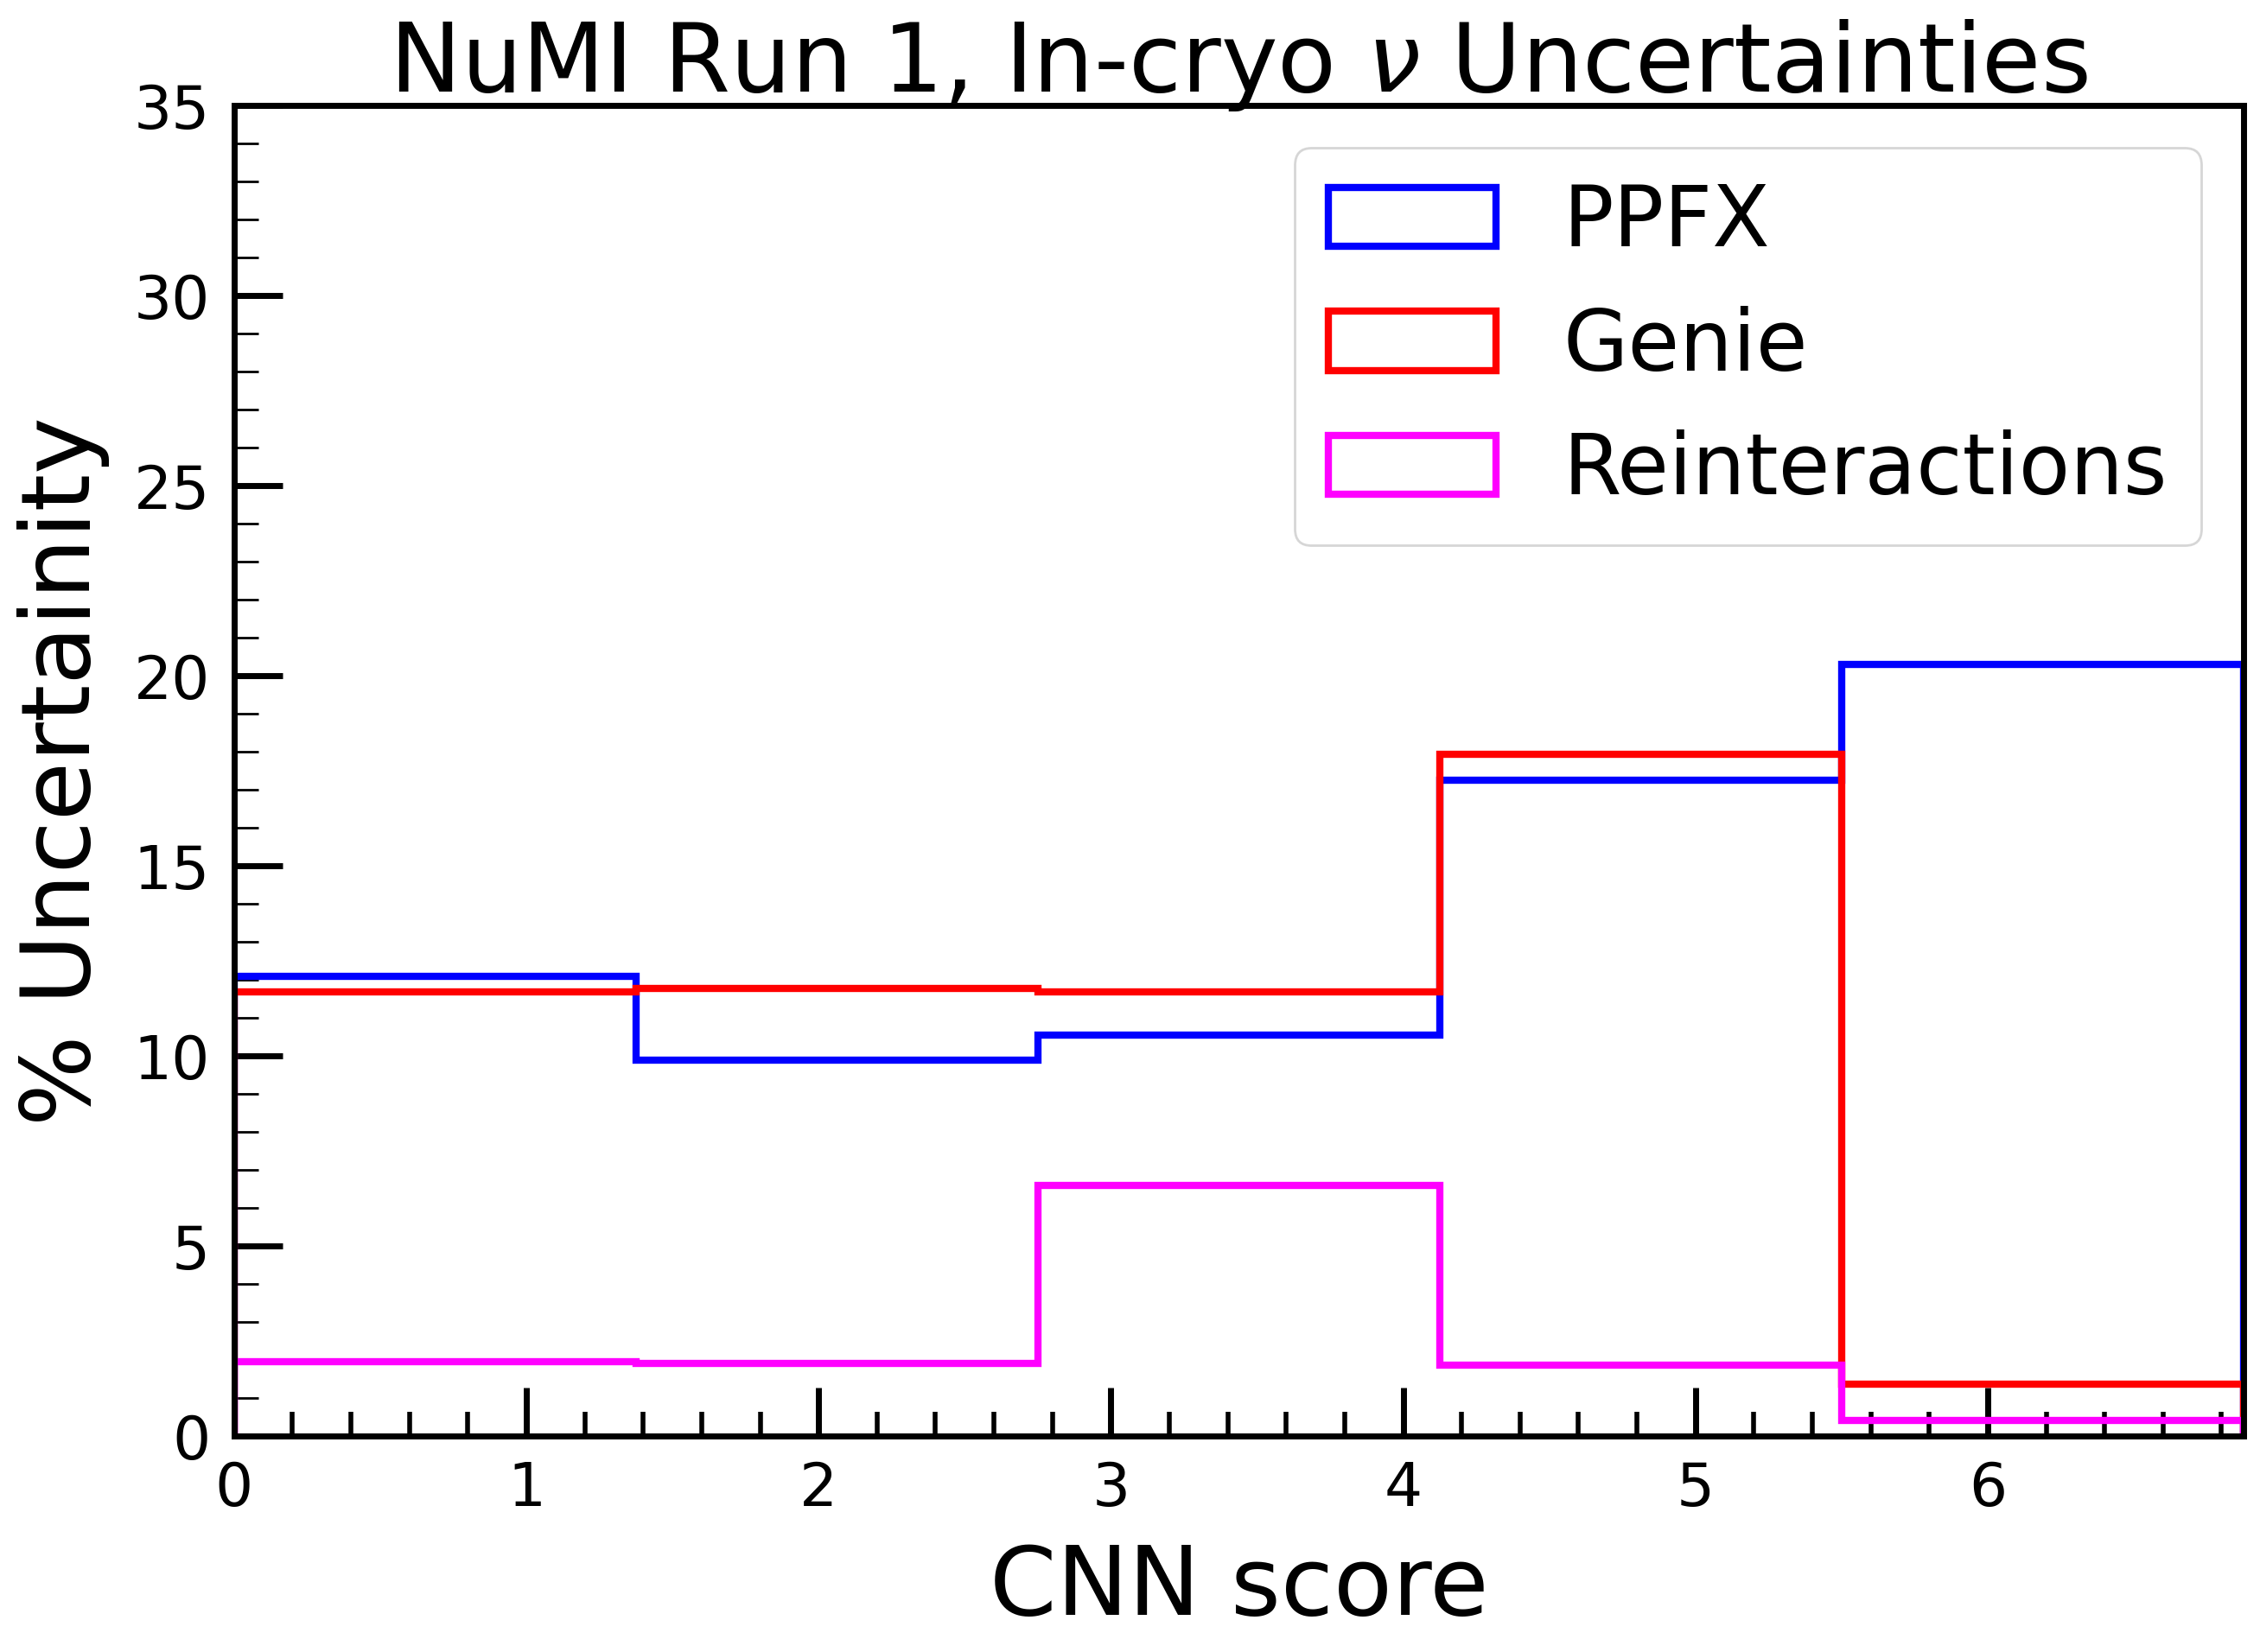

In [7]:
fig = plt.figure(figsize=(15,10),dpi=200)
ax = fig.add_subplot(111)
nbins = 20

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2.5)  # change width
    ax.spines[axis].set_color('black')    # change color
    
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.hist(bins_final[:-1],bins_final,weights=error_hists[0][1], color = "blue",label='PPFX', histtype="step",lw=3,linestyle="-")
plt.hist(bins_final[:-1],bins_final,weights=error_hists[1][1], color = "red",label='Genie', histtype="step",lw=3,linestyle="-")
plt.hist(bins_final[:-1],bins_final,weights=error_hists[2][1], color = "magenta",label='Reinteractions', histtype="step",lw=3,linestyle="-")
plt.tick_params(axis="y", which='major', direction="in",length=20,width=2.5,pad=10)
plt.tick_params(axis="y", which='minor', direction="in",length=10,width=1.0,labelleft=False)
plt.tick_params(axis="x", which='major', direction="in",length=20,width=2.5,pad=10)
plt.tick_params(axis="x", which='minor', direction="in",length=10,width=2.0,labelbottom=False)
plt.legend(fontsize=35)
plt.ylim(0.,35.)
plt.xlim(0.,final_custom_bins[-1])
plt.xticks(size=25)
plt.yticks(size=25)
plt.title(run_flag + r', In-cryo $\nu$ Uncertainties',fontsize=40)
plt.ylabel("% Uncertainity",fontsize=40,labelpad=10)
plt.xlabel("CNN score", fontsize=40, labelpad=10)
plt.savefig(fig_dir + run + "_CNN_multisim_errors.png")

In [8]:
import uproot as u

base_dir = "/home/lmlepin/Desktop/dm_sets/dark_tridents_analysis/" + run + "_samples/"
bkg_file = u.update(base_dir + "background_hist_" + run + "_CNN.root")

bkg_file['bkg_ppfx_uncertainty_frac'] = (error_hists[0][1]/100.,bins_final)
bkg_file['bkg_genie_uncertainty_frac'] = (error_hists[1][1]/100.,bins_final)
bkg_file['bkg_reinteraction_uncertainty_frac'] = (error_hists[2][1]/100.,bins_final)

bkg_file['bkg_ppfx_uncertainty_abs'] = (abs_error_hists[0][1],bins_final)
bkg_file['bkg_genie_uncertainty_abs'] = (abs_error_hists[1][1],bins_final)
bkg_file['bkg_reinteraction_uncertainty_abs'] = (abs_error_hists[2][1],bins_final)